# OpenClassrooms - projet 3 : OpenFoodFacts

Contexte : élaborer une idée d'application exploitant les données fournies par Open Food Facts.

Idée d'application : estimer le nutriscore d'un produit à partir de la photo du produit. 


Le nutri-score des aliments repose sur le calcul d’un score unique et global prenant en compte, pour chaque aliment :

- une composante dite « négative » N composée des nutriments et aliments à favoriser (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- une composante dite « positive » P composée des nutriments à limiter (énergie, acides gras saturés, sucres, sel).

Tout d'abord il convient de réaliser une exploration des données pour sélectionner les variables qui contiennent les données qui se trouvent sur l'emballage d'un produit. Puis nous devons déterminer si des corrélations existent entre ces variables et le nutri-score.

## Imports and config

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# other
from tqdm import tqdm
import gc, os, warnings, requests, swifter, pickle

# data visualization
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display

# NLP
import re, fasttext, spacy
from unidecode import unidecode
import en_core_web_sm, fr_core_news_md
from collections import Counter

# image
import urllib.request

# statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols

# config
warnings.filterwarnings('ignore')
tqdm.pandas()
pd.set_option("display.max_columns", 200)

storage_path = '/home/jupyter/data/openclassroom/p3/'

In [2]:
filepath = os.path.join(storage_path, 'en.openfoodfacts.org.products.pkl')
df = pd.read_pickle(filepath)

## Data preparation

In [3]:
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615984 entries, 0 to 1615983
Data columns (total 184 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   code                                        1615984 non-null  object 
 1   url                                         1615984 non-null  object 
 2   creator                                     1615980 non-null  object 
 3   created_t                                   1615984 non-null  int64  
 4   created_datetime                            1615984 non-null  object 
 5   last_modified_t                             1615984 non-null  int64  
 6   last_modified_datetime                      1615984 non-null  object 
 7   product_name                                1526408 non-null  object 
 8   abbreviated_product_name                    922 non-null      object 
 9   generic_name                                109723 non-n

In [3]:
# fetching features categories
url = 'https://world.openfoodfacts.org/data/data-fields.txt'
features_description = requests.get(url).text
features_dict = {i.split('\n\n')[0].strip()[:-1]: 
                 [j.split(':')[0].strip() for j in i.split('\n\n')[1].strip().split('\n')]
                 for i in features_description.split('#')[1:]}

In [4]:
# clean features names
df.columns = [c[1:] if c.startswith('-') else c for c in df.columns]

In [6]:
feature_doc = [value for key, value in features_dict.items()]
feature_doc = [item for sublist in feature_doc for item in sublist]

In [7]:
len(feature_doc), len(df.columns)

(142, 184)

In [8]:
len(list(set(df.columns) - set(feature_doc)))

47

In [9]:
len(list(set(feature_doc) - set(df.columns)))

5

La documentation n'est pas fidèle aux données, 5 variables dans la documentation ne sont pas présente en base et 47 de la base ne sont pas présente dans la documentation.

In [10]:
# clean feature dict
_features_to_remove = list(set(feature_doc) - set(df.columns))
_feature_to_add = list(set(df.columns) - set(feature_doc))
_nutrition_facts_features_to_add = [f for f in _feature_to_add if f.endswith('100g')]
_others_features_to_add = [f for f in _feature_to_add if not f.endswith('100g')]

for f in _features_to_remove:
    for key, item in features_dict.items():
        if f in item:
            item.remove(f)
            
features_dict['nutrition facts'] += _nutrition_facts_features_to_add
features_dict['general information'] += _others_features_to_add 

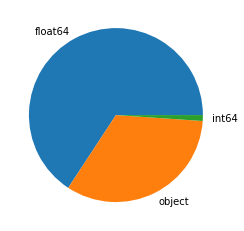

In [11]:
columns_types = [df[c].dtypes.name for c in df.columns]
plt.figure()
pd.Series(columns_types, name = '').value_counts().plot(kind='pie')
plt.show()

Pour ne pas biaisier l'analyse exploratoire des données, nous allons travailler uniquement sur les données labellisées.

In [12]:
df_no_lab = df.loc[df.nutriscore_grade.isna()].reset_index(drop = True)
df = df.loc[df.nutriscore_grade.notna()].reset_index(drop = True)

In [13]:
len(df_no_lab), len(df)

(987244, 628740)

## Features selection

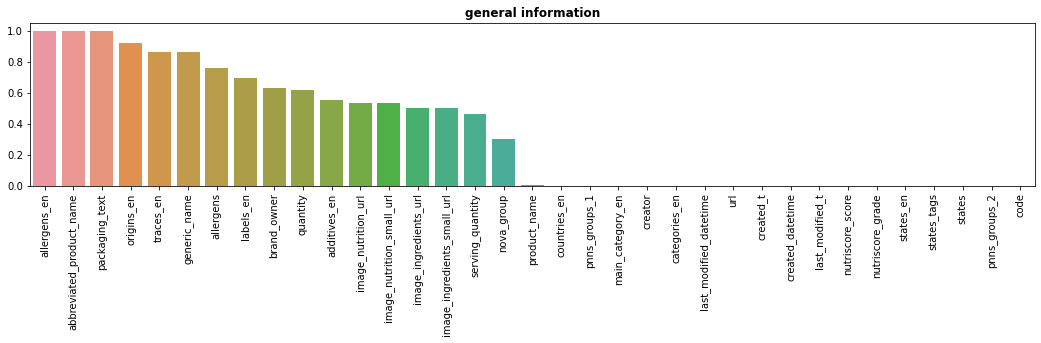

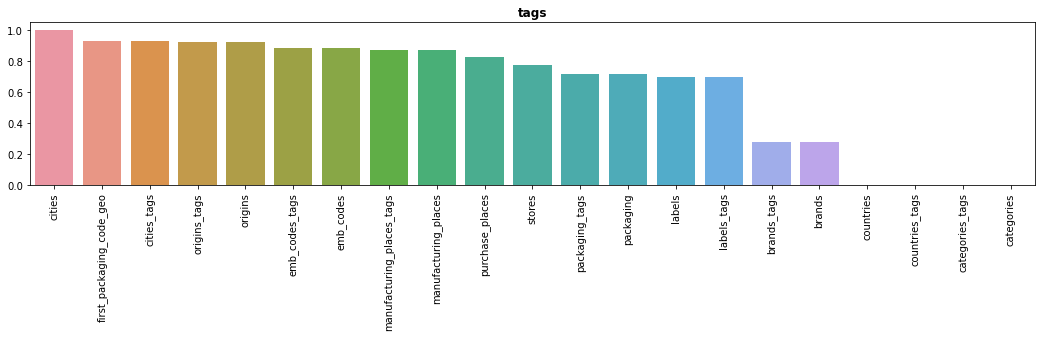

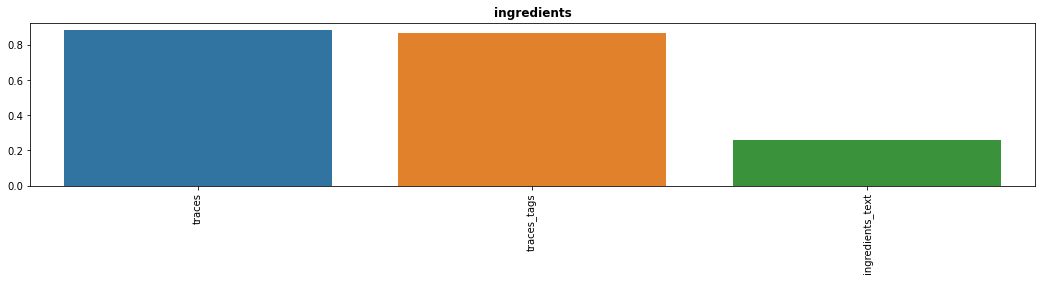

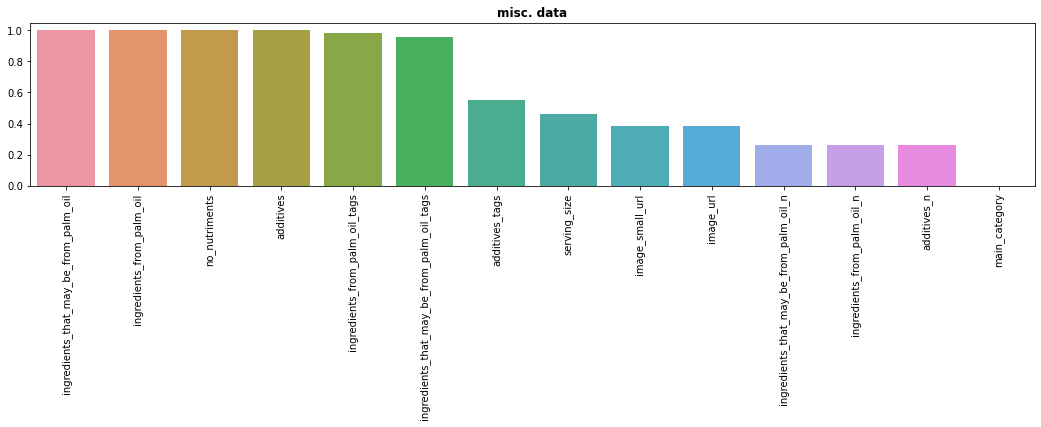

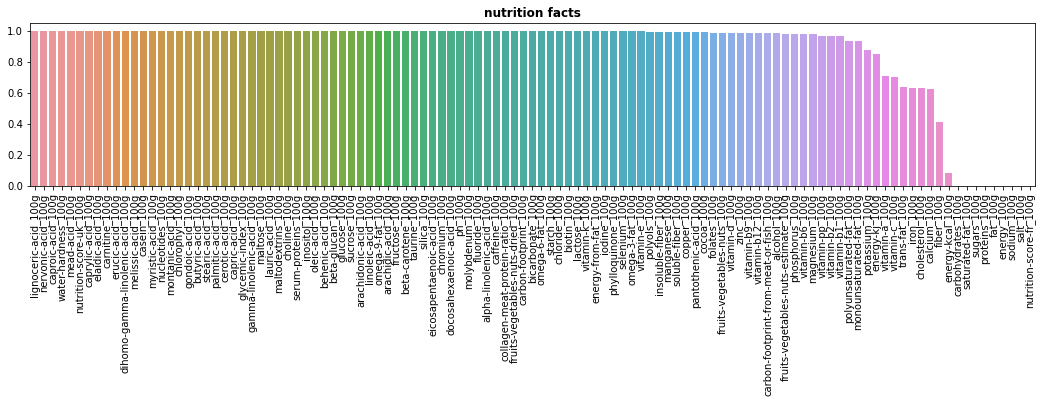

In [14]:
for cat in features_dict.keys():
    features = df.columns[df.columns.isin(features_dict[cat])]
    serie = (df[features].isnull().sum() / len(df[features])).sort_values(ascending = False)
    plt.figure(figsize = (18, 3))
    plt.title(cat, weight = 'bold')
    sns.barplot(serie.index, serie.values)
    plt.xticks(rotation = 90)
    plt.show()

In [15]:
missing_value_rates = (df.isnull().sum() / len(df)).sort_values(ascending = False)

In [17]:
missing_value_rates.median(), missing_value_rates.mean()

(0.9834621624200783, 0.7239782100432748)

Exclusion des variables qui ont plus de 60 % de valeurs manquantes.

In [16]:
selected_feature = missing_value_rates[missing_value_rates < 0.6].index

Dans ces features certaines attraient à seulement à des considérations autres que les produits, comme code ou url, il convient de les supprimer.

In [17]:
features_to_remove = ['code', 'url', 'creator', 'created_datetime', 'created_t', 'last_modified_datetime', 'last_modified_t']
selected_feature = [f for f in selected_feature if f not in features_to_remove]

In [18]:
len(selected_feature)

44

In [19]:
df = df[selected_feature]

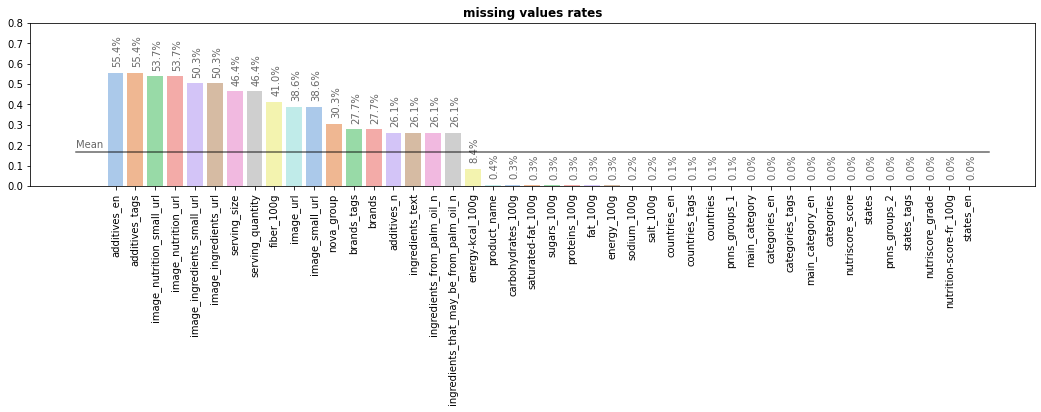

In [20]:
serie = (df.isnull().sum() / len(df)).sort_values(ascending = False)

plt.figure(figsize = (18, 3))
plt.title('missing values rates', weight = 'bold')
sns.barplot(serie.index, serie.values, palette='pastel')
plt.xticks(rotation = 90)
x = np.arange(-2, len(df.columns) + 1)
y = np.ones(len(df.columns) + 3)* serie.mean()
plt.plot(x, y, c = 'black', alpha = 0.6)
plt.text(x = -2, y = serie.mean() + 0.02, s = 'Mean', c = 'black', alpha = 0.6)

for i in range(len(serie)):
    plt.text(x = i - 0.15,
             y = serie.values[i] + 0.04,
             s = f'{serie.values[i]:.1%}',
             alpha = 0.6,
             rotation = 90)

plt.gca().set_ylim([0,0.8])

plt.show()

Selection des variables qui contiennent des données présentes sur l’emballage d’un produit :

In [21]:
selected_feature = [
    'image_url', 
    'ingredients_text', 
    'brands', 
    'product_name', 
    'serving_size',
    'sugars_100g',
    'proteins_100g',
    'fat_100g',
    'salt_100g',
    'energy_100g',
    'nutriscore_score', 
    'nutriscore_grade'
]

In [22]:
df = df[selected_feature]

In [23]:
df.shape

(628740, 12)

(0.0, 224903.0)

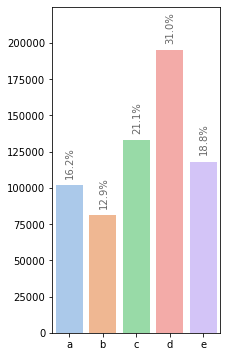

In [62]:
plt.figure(figsize = (3, 6))
sns.barplot(x = df.nutriscore_grade.value_counts().sort_index().index, y = df.nutriscore_grade.value_counts().sort_index().values, palette = 'pastel')
for i, grade in enumerate(nutriscore_grade):
    plt.text(x = i - 0.12,
             y = df.nutriscore_grade.value_counts()[grade] + 6000,
             s = f'{df.nutriscore_grade.value_counts(normalize = True)[grade]:.1%}',
             alpha = 0.6,
             rotation = 90)

plt.gca().set_ylim([0, max(df.nutriscore_grade.value_counts()) + 30000])

In [24]:
df.to_feather(os.path.join(storage_path, 'data.f'))

## Data preprocessing, feature engineering & correlation analysis

In [3]:
df = pd.read_feather(os.path.join(storage_path, 'data.f')) 

nutriscore_grade = df.nutriscore_grade.unique()[pd.notnull(df.nutriscore_grade.unique())]
nutriscore_grade.sort()

### Nutrition variables

In [4]:
nutrition_variables = [
    'sugars_100g',
    'proteins_100g',
    'fat_100g',
    'salt_100g',
    'energy_100g',
    'nutriscore_score', 
    'nutriscore_grade'
]

#### Exemples

In [13]:
df[nutrition_variables].sample(10)

,sugars_100g,proteins_100g,fat_100g,salt_100g,energy_100g,nutriscore_score,nutriscore_grade
358906,4.60,5.10,10.00,0.1000,540.0,5.0,c
409617,0.00,26.00,7.50,1.5000,720.0,4.0,c
429435,7.90,0.80,0.50,0.0000,163.0,2.0,c
111136,0.00,25.00,32.14,1.6075,1644.0,16.0,d
583300,0.03,27.50,39.50,3.4800,1962.0,25.0,e
258236,2.30,5.70,9.30,0.7000,659.0,4.0,c
300889,0.00,21.00,20.00,2.7600,1117.0,17.0,d
503214,28.00,8.30,1.80,15.0000,1230.0,19.0,e
519320,11.00,25.00,51.00,1.1000,2602.0,23.0,e
254016,3.54,0.88,0.88,0.9725,146.0,4.0,c


#### Analyse univariée

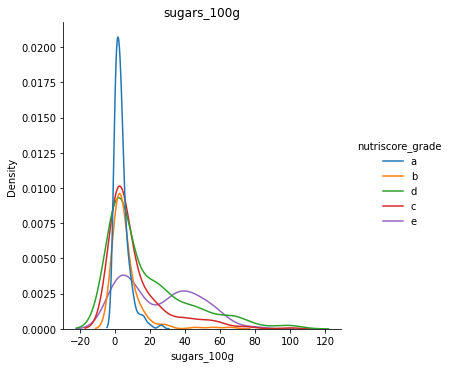

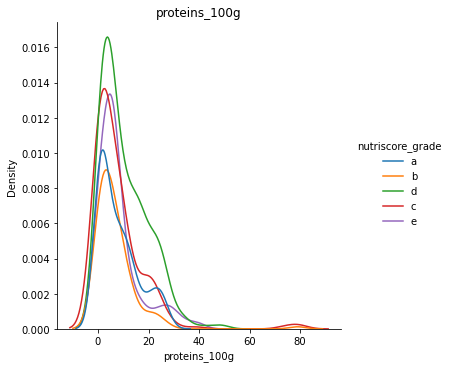

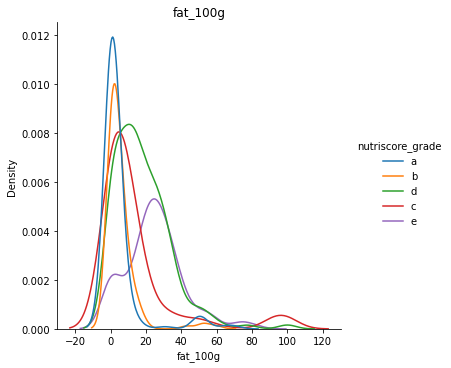

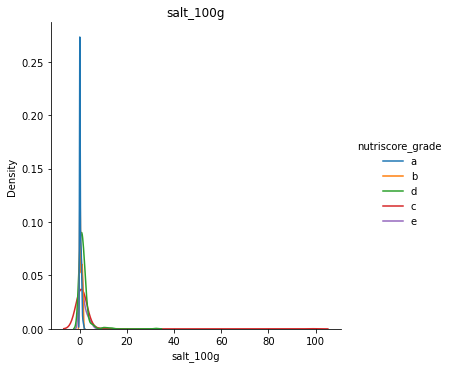

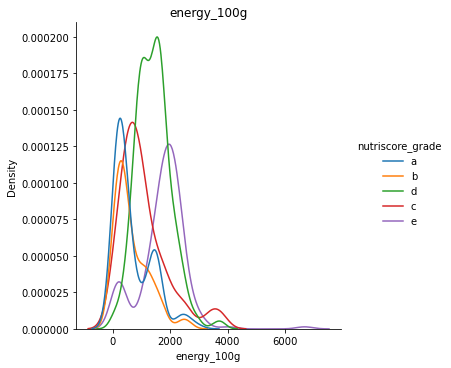

In [5]:
data = df.sample(1000)
for var in nutrition_variables[:-2]:
    sns.displot(x = var, hue = 'nutriscore_grade', data = data, kind  = 'kde')
    plt.title(var)

#### Analyse bivariée

<Figure size 432x288 with 0 Axes>

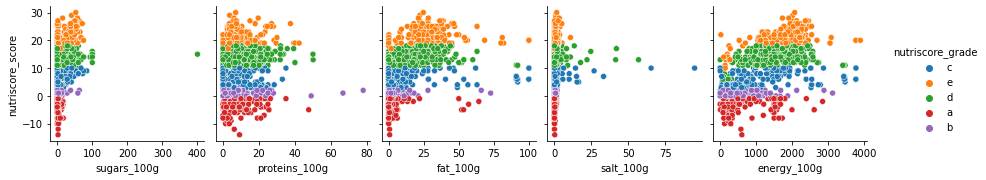

In [7]:
plt.figure()
sns.pairplot(data = df[nutrition_variables].sample(1000), 
             x_vars = ['sugars_100g', 'proteins_100g', 'fat_100g', 'salt_100g', 'energy_100g'],
             y_vars = ['nutriscore_score'],
             hue = 'nutriscore_grade', 
             diag_kind= "kde")
plt.savefig(os.path.join('charts', 'pairplot_nutrition_variables.png'))
plt.show()

#### Heatmap

<AxesSubplot:>

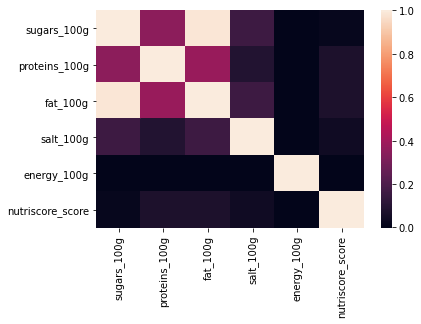

In [16]:
sns.heatmap(df[nutrition_variables].corr())

#### Anova

In [35]:
for var in nutrition_variables[:-2]:
    results = ols(f'\n{var} ~ nutriscore_grade', data=df).fit()
    print(f"\n{24*' '}{var}\n{60*'_'}")
    display(results.summary(alpha = .05))


                        sugars_100g
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sugars_100g   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     30.16
Date:                Mon, 22 Mar 2021   Prob (F-statistic):           3.92e-25
Time:                        21:38:18   Log-Likelihood:            -4.9253e+06
No. Observations:              627030   AIC:                         9.851e+06
Df Residuals:                  627025   BIC:                         9.851e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.7480      1.973      1.900      0.057      -0.119       7.614
nutriscore_grade[T.b]     1.1261      2.947      0.382      0.702      -4.650       6.902
nutriscore_grade[T.c]     6.7384      2.612      2.580      0.010       1.619      11.858
nutriscore_grade[T.d]    12.5945      2.427      5.190      0.000       7.838      17.351
nutriscore_grade[T.e]    25.3700      2.681      9.461      0.000      20.115      30.626
=================================================================================
Omnibus:                  4399082.326   Durbin-Watson:                      1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   10240214567811800.000
Skew:                         790.934   Prob(JB):                            0.00
Kurtosis:                  626061.048   Cond. No.                            6.56
=================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        proteins_100g
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          proteins_100g   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2714.
Date:                Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:38:19   Log-Likelihood:            -2.3180e+06
No. Observations:              627042   AIC:                         4.636e+06
Df Residuals:                  627037   BIC:                         4.636e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.3619      0.031    271.121      0.000       8.301       8.422
nutriscore_grade[T.b]    -1.2075      0.046    -26.209      0.000      -1.298      -1.117
nutriscore_grade[T.c]    -1.2038      0.041    -29.481      0.000      -1.284      -1.124
nutriscore_grade[T.d]     1.9170      0.038     50.526      0.000       1.843       1.991
nutriscore_grade[T.e]    -0.3519      0.042     -8.393      0.000      -0.434      -0.270
==============================================================================
Omnibus:                  2039434.123   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    5075558427670.262
Skew:                          53.692   Prob(JB):                         0.00
Kurtosis:                   13940.547   Cond. No.                         6.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        fat_100g
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fat_100g   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     683.9
Date:                Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:38:21   Log-Likelihood:            -3.8900e+06
No. Observations:              627043   AIC:                         7.780e+06
Df Residuals:                  627038   BIC:                         7.780e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.9027      0.378     10.314      0.000       3.161       4.644
nutriscore_grade[T.b]     1.1717      0.565      2.073      0.038       0.064       2.280
nutriscore_grade[T.c]     8.8401      0.501     17.646      0.000       7.858       9.822
nutriscore_grade[T.d]    14.2334      0.465     30.578      0.000      13.321      15.146
nutriscore_grade[T.e]    22.8640      0.514     44.454      0.000      21.856      23.872
================================================================================
Omnibus:                  4371243.520   Durbin-Watson:                     1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   9544027183602858.000
Skew:                         770.321   Prob(JB):                           0.00
Kurtosis:                  604398.722   Cond. No.                           6.56
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        salt_100g
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              salt_100g   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     230.0
Date:                Mon, 22 Mar 2021   Prob (F-statistic):          1.01e-197
Time:                        21:38:23   Log-Likelihood:            -2.5943e+06
No. Observations:              627456   AIC:                         5.189e+06
Df Residuals:                  627451   BIC:                         5.189e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2967      0.048      6.221      0.000       0.203       0.390
nutriscore_grade[T.b]     0.2921      0.071      4.095      0.000       0.152       0.432
nutriscore_grade[T.c]     1.1105      0.063     17.571      0.000       0.987       1.234
nutriscore_grade[T.d]     1.4705      0.059     25.047      0.000       1.355       1.586
nutriscore_grade[T.e]     1.4538      0.065     22.405      0.000       1.327       1.581
==============================================================================
Omnibus:                  2459919.543   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    3179728086316.727
Skew:                          96.408   Prob(JB):                         0.00
Kurtosis:                   11029.625   Cond. No.                         6.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        energy_100g
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_100g   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9288
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.446
Time:                        21:38:25   Log-Likelihood:            -1.2041e+07
No. Observations:              627088   AIC:                         2.408e+07
Df Residuals:                  627083   BIC:                         2.408e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               690.4073   1.67e+05      0.004      0.997   -3.27e+05    3.28e+05
nutriscore_grade[T.b]   -70.4730    2.5e+05     -0.000      1.000   -4.89e+05    4.89e+05
nutriscore_grade[T.c]  3.153e+05   2.21e+05      1.426      0.154   -1.18e+05    7.49e+05
nutriscore_grade[T.d]   732.8300   2.05e+05      0.004      0.997   -4.02e+05    4.03e+05
nutriscore_grade[T.e]  1109.7348   2.27e+05      0.005      0.996   -4.44e+05    4.46e+05
=================================================================================
Omnibus:                  4400755.311   Durbin-Watson:                      2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   10274477073197584.000
Skew:                         791.880   Prob(JB):                            0.00
Kurtosis:                  627078.531   Cond. No.                            6.56
=================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Text variables

#### Exemples

In [11]:
print(df.ingredients_text.sample(3).values)
print()

['Pasteurized milk, red and green jalapeno peppers, cheese cultures, salt and enzymes.'
 'Organic milk, organic cream, organic cane sugar, organic butter pecan pieces (organic pecans, organic safflower and/or organic sunflower oil, salt, organic butter), organic nonfat milk, organic egg yolks, natural flavor, organic locust bean gum, organic guar gum.'
 'Cultured pasteurized grade a low fat milk, sugar, water, food starch-modified, cherries, natural flavor, carrageenan, pectin, citric acid, fruit and vegetable juice (color), vitamin a palmitate, vitamin d3.']



In [12]:
print(df.product_name.sample(3).values)
print()

["Confit D'echalotes" 'Cranberries'
 'Cookies, fudge, peanut butter & crunchy nut']



#### Recherche des langues

Au regard des données les données de textes sont dans des langues différentes, ce qui les rends incomparables si on les prends dans leur totalité. Il convient de détecter la langue en amont pour les classers selon leur language. Pour ce faire, j'utilise un modèle FastText (développé par Facebook).

Toutefois si product_name contient des mots qui peuvent définir le produit et donc issus d'une langue, la marque n'est pas exploitable pour détecter la langue.

In [64]:
model = fasttext.load_model(os.path.join(storage_path, 'models', 'lid.176.bin'))

In [65]:
def get_language(x, model):
    try:
        prediction, accuracy = model.predict(x, k=1)  # top 2 matching languages
        if accuracy[0] >= 0.5:
            return prediction[0][-2:]
        else:
            return np.NaN
    except:
        return np.NaN

In [66]:
df['ingredients_text_product_name'] = df.ingredients_text + ' ' + df.product_name
df['ingredients_text_product_name_language'] = df.ingredients_text_product_name.swifter.apply(lambda x: get_language(x, model))

Pandas Apply:   0%|          | 0/628740 [00:00<?, ?it/s]

In [68]:
df.to_feather(os.path.join(storage_path, 'data.f'))

Le modèle à détecter une langue pour plus de 70% des textes et 50% des textes sont en français et en anglais, on va se concentrer pour notre analyse uniquement sur ces deux langues. Il convient alors de normaliser nos textes (enlever les accents, la ponctuaction, les nombres, les caractères spéciaux, et les stops-words) puis de les transformer en token. Pour cela on utilise la librairie Spacy.

In [19]:
df_en = df.loc[df.ingredients_text_product_name_language == 'en']
df_fr = df.loc[df.ingredients_text_product_name_language == 'fr']

In [70]:
len(df_en), len(df_fr)

(232345, 137709)

On se retrouve avec 232345 textes en anglais et 137709 textes français.

In [71]:
df.ingredients_text_product_name_language.value_counts(normalize=True, dropna=False)[:5]

en     0.369541
NaN    0.334763
fr     0.219024
de     0.035487
es     0.019351
Name: ingredients_text_product_name_language, dtype: float64

#### Preprocessing

In [7]:
#!python3 -m spacy download en_core_web_sm
#!python3 -m spacy download fr_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [9]:
nlp_en = en_core_web_sm.load()
nlp_fr = fr_core_news_md.load()

In [17]:
def preprocessing(doc):
    doc = [unidecode(token.lemma_).lower() for token in doc \
           if not token.is_stop \
           and not token.is_punct \
           and token.is_alpha \
           and len(token) > 1]
    return doc

nlp_en.add_pipe(preprocessing, after = 'parser')
nlp_fr.add_pipe(preprocessing, after = 'parser')

In [20]:
docs_en = nlp_en.pipe(df_en.ingredients_text, disable = 'ner', batch_size = 20)
tokens_en = [doc for doc in tqdm(docs_en)]

232345it [17:57, 215.66it/s]


In [21]:
docs_fr = nlp_fr.pipe(df_fr.ingredients_text, disable = 'ner', batch_size = 20)
tokens_fr = [doc for doc in tqdm(docs_fr)]

137709it [12:00, 191.19it/s]


In [22]:
df_en['ingredients_text_product_name_token'] = tokens_en
df_en.reset_index().to_feather(os.path.join(storage_path, 'data_en.f'))

df_fr['ingredients_text_product_name_token'] = tokens_fr
df_fr.reset_index().to_feather(os.path.join(storage_path, 'data_fr.f'))

In [24]:
df['ingredients_text_product_name_token'] = pd.concat([df_en.ingredients_text_product_name_token, df_fr.ingredients_text_product_name_token]).sort_index()

In [26]:
df.to_feather(os.path.join(storage_path, 'data.f'))

#### Feature engineering

La première feature extraire est le nombre de token par texte.

In [27]:
def get_len(x):
    try:
        return len(x)
    except:
        return np.NaN

In [80]:
df['ingredients_text_product_name_nb_token'] = df.ingredients_text_product_name_token.swifter.apply(get_len)

Pandas Apply:   0%|          | 0/628740 [00:00<?, ?it/s]

Puis le nombre de lettre dans par texte.

In [29]:
def get_nb_character(token_list):
    try:
        lenght = 0
        for token in token_list:
            lenght += len(token)
        return lenght
    except:
        return np.NaN

In [30]:
df['ingredients_text_product_name_nb_character'] = df.ingredients_text_product_name_token.swifter.apply(get_nb_character)

Pandas Apply:   0%|          | 0/628740 [00:00<?, ?it/s]

Enfin j'extraire les corpus de chacun des grades pour créer le corpus common à tous les grades. Puis créer une feature avec le nombre de token par texte qui appartient à ce corpus commun. Ce que l'on cherche à savoir c'est si des grades se démarquent par une plus grandes originalité de leurs tokens.

In [33]:
for grade in tqdm(nutriscore_grade):
    corpus = df_en.loc[df_en.nutriscore_grade == grade].ingredients_text_product_name_token.values
    locals()['corpus_en_' + grade] = list(set([token for text in corpus for token in text]))
    
for grade in tqdm(nutriscore_grade):
    corpus = df_fr.loc[df_fr.nutriscore_grade == grade].ingredients_text_product_name_token.values
    locals()['corpus_fr_' + grade] = list(set([token for text in corpus for token in text]))

100%|██████████| 5/5 [00:00<00:00,  8.28it/s]


In [34]:
common_corpus_en = np.array(list(set(corpus_en_a) & set(corpus_en_b) & set(corpus_en_c) & set(corpus_en_d) & set(corpus_en_e)))
common_corpus_fr = np.array(list(set(corpus_fr_a) & set(corpus_fr_b) & set(corpus_fr_c) & set(corpus_fr_d) & set(corpus_fr_e)))

In [35]:
len(common_corpus_en), len(common_corpus_fr)

(2390, 3089)

In [36]:
pickle.dump(common_corpus_en, open(os.path.join(storage_path, 'common_corpus_en.p'), 'wb'))
pickle.dump(common_corpus_fr, open(os.path.join(storage_path, 'common_corpus_fr.p'), 'wb'))

In [37]:
def compute_common_corpus_presence(token_list, common_corpus):
    return np.isin(token_list, common_corpus).sum()

In [38]:
df_en['common_corpus_token'] = df_en.ingredients_text_product_name_token.swifter.apply(lambda x: compute_common_corpus_presence(x, common_corpus_en))
df_fr['common_corpus_token'] = df_fr.ingredients_text_product_name_token.swifter.apply(lambda x: compute_common_corpus_presence(x, common_corpus_fr))

Pandas Apply:   0%|          | 0/232345 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/137709 [00:00<?, ?it/s]

In [39]:
df['ingredients_text_product_name_common_corpus_token'] = pd.concat([df_en.common_corpus_token, df_fr.common_corpus_token]).sort_index()

In [83]:
df.to_feather(os.path.join(storage_path, 'data.f'))

#### WordCloud

In [63]:
wc = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1')

In [50]:
english_tokens = [t for doc in tqdm(df_en.ingredients_text_product_name_token.values) for t in doc]
french_tokens = [t for doc in tqdm(df_fr.ingredients_text_product_name_token.values) for t in doc]

100%|██████████| 137709/137709 [00:00<00:00, 969119.71it/s]


In [53]:
len(english_tokens), len(french_tokens)

(8357321, 3690023)

In [55]:
token_frequency_en = Counter(english_tokens)
token_frequency_fr = Counter(french_tokens)

In [61]:
len(token_frequency_en), len(token_frequency_fr)

(20308, 49690)

In [68]:
pickle.dump(token_frequency_en, open(os.path.join(storage_path, 'token_frequency_en.p'), 'wb'))
pickle.dump(token_frequency_fr, open(os.path.join(storage_path, 'token_frequency_fr.p'), 'wb'))

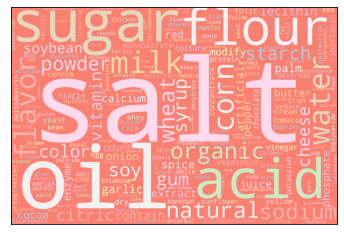

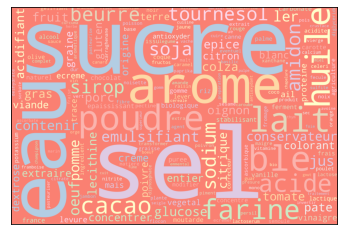

In [64]:
wc_en = wc.generate_from_frequencies(token_frequency_en)
plt.figure()
plt.imshow(wc_en)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join('charts', 'wordcloud_en.png'))

wc_fr = wc.generate_from_frequencies(token_frequency_fr)
plt.figure()
plt.imshow(wc_fr)
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join('charts', 'wordcloud_en.png'))

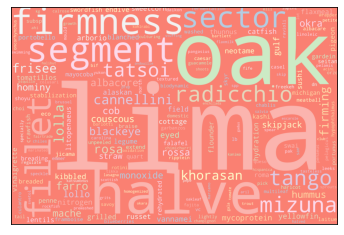

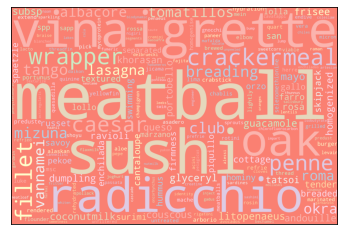

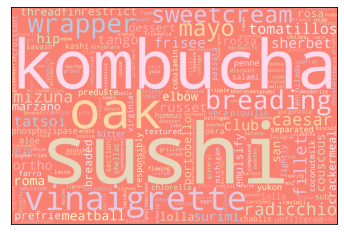

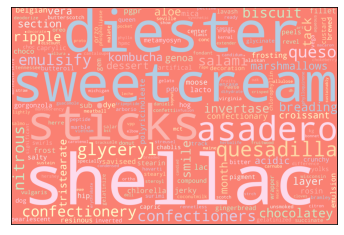

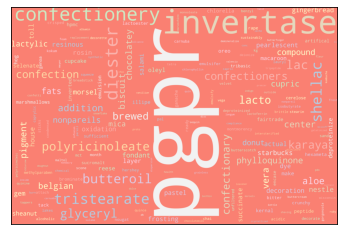

In [72]:
for grade in nutriscore_grade:
    en_token_temp = [t for doc in df_en.loc[df_en.nutriscore_grade == grade, 'ingredients_text_product_name_token'].values for t in doc]
    token_freq_en_temp = pd.Series(Counter(en_token_temp))
    token_freq_en_temp = token_freq_en_temp[~ token_freq_en_temp.index.isin(common_corpus_en)]
    token_freq_en_temp = dict(token_freq_en_temp)

    wc_en = wc.generate_from_frequencies(token_freq_en_temp)
    plt.figure()
    plt.imshow(wc_en)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join('charts', f'wordcloud_en_{grade}.png'))

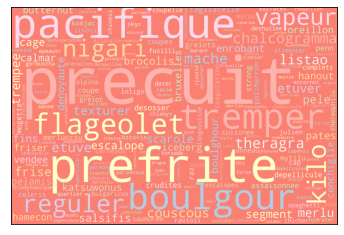

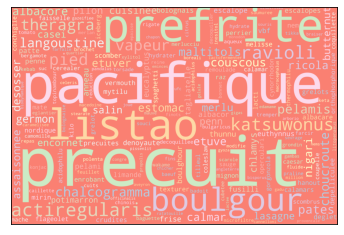

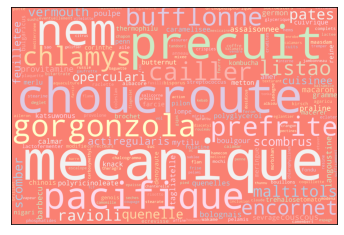

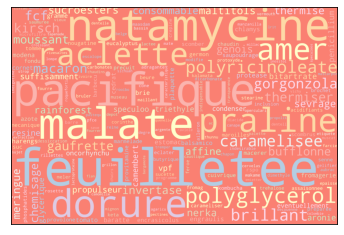

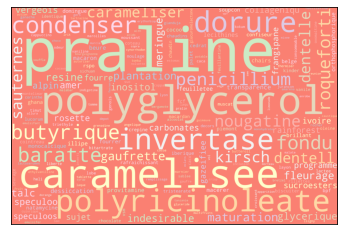

In [74]:
for grade in nutriscore_grade:
    
    token_freq_fr_temp = [t for doc in df_fr.loc[df_fr.nutriscore_grade == grade, 'ingredients_text_product_name_token'].values for t in doc]
    token_freq_fr_temp = pd.Series(Counter(token_freq_fr_temp))
    token_freq_fr_temp = token_freq_fr_temp[~ token_freq_fr_temp.index.isin(common_corpus_fr)]
    token_freq_fr_temp = dict(token_freq_fr_temp)

    wc_en = wc.generate_from_frequencies(token_freq_fr_temp)
    plt.figure()
    plt.imshow(wc_fr)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join('charts', f'wordcloud_fr_{grade}.png'))

#### Analyse bivariée

In [85]:
df_en_fr = df.loc[(df.ingredients_text_product_name_language == 'en') | (df.ingredients_text_product_name_language == 'fr')]

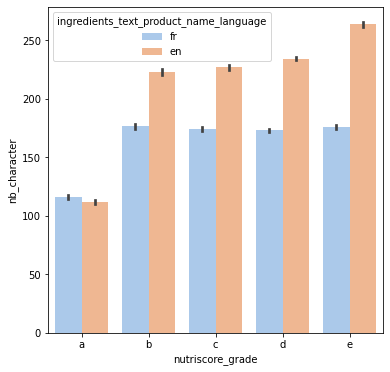

In [96]:
plt.figure(figsize = (6, 6))
sns.barplot(x="nutriscore_grade", 
            y="ingredients_text_product_name_nb_character", 
            hue="ingredients_text_product_name_language",
            data=df_en_fr, 
            order = ['a', 'b', 'c', 'd', 'e'],
            palette='pastel')
plt.ylabel('nb_character')
plt.savefig(os.path.join('charts', f'univar_bar_nb_character.png'))

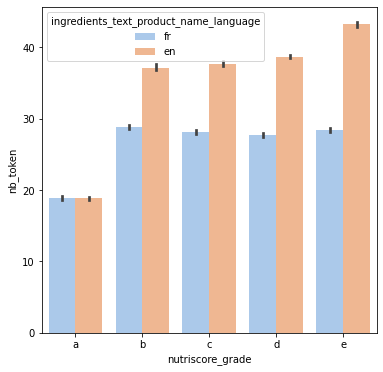

In [97]:
plt.figure(figsize = (6, 6))
sns.barplot(x="nutriscore_grade", 
            y="ingredients_text_product_name_nb_token", 
            hue="ingredients_text_product_name_language", 
            data=df_en_fr, 
            order = ['a', 'b', 'c', 'd', 'e'],
            palette='pastel')
plt.ylabel('nb_token')
plt.savefig(os.path.join('charts', f'univar_bar_nb_token.png'))

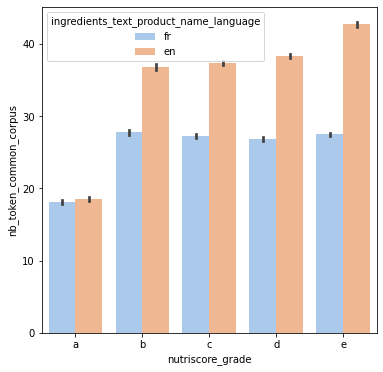

In [98]:
plt.figure(figsize = (6, 6))
sns.barplot(x="nutriscore_grade", 
            y="ingredients_text_product_name_common_corpus_token", 
            hue="ingredients_text_product_name_language", 
            data=df_en_fr, 
            order = ['a', 'b', 'c', 'd', 'e'],
            palette='pastel')
plt.ylabel('nb_token_common_corpus')
plt.savefig(os.path.join('charts', f'univar_bar_common_corpus_token".png'))

In [ ]:
df_en_fr = df.loc[(df.ingredients_text_product_name_language == 'en') | (df.ingredients_text_product_name_language == 'fr')]

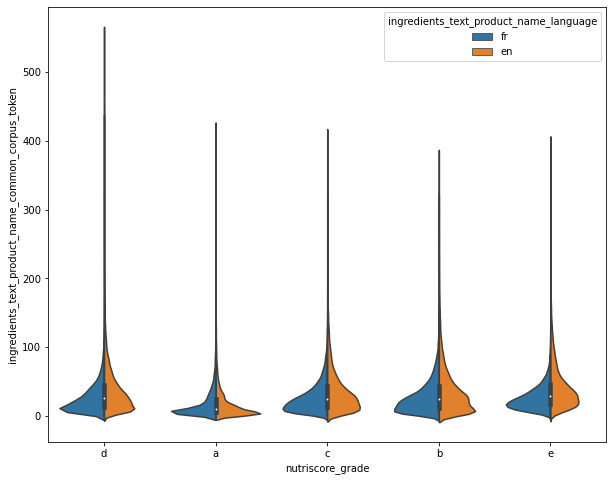

In [100]:
plt.figure(figsize = (10, 8))
sns.violinplot(x= 'nutriscore_grade',y= 'ingredients_text_product_name_common_corpus_token', hue="ingredients_text_product_name_language",  data=df_en_fr, split = True, scale = 'area')
plt.savefig(os.path.join('charts', 'violon_text_common_corpus_token.png'))

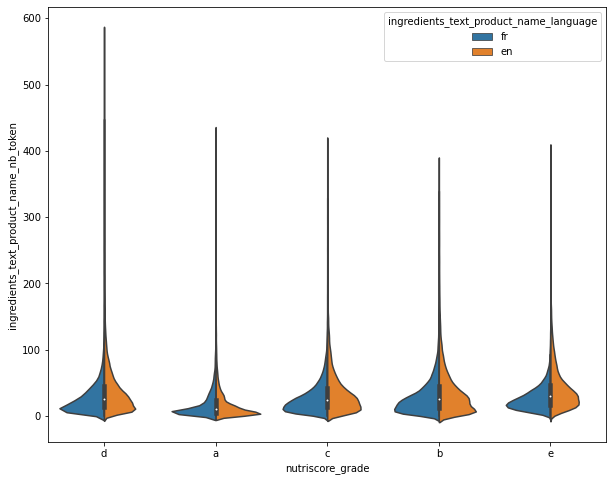

In [101]:
plt.figure(figsize = (10, 8))
sns.violinplot(x= 'nutriscore_grade',y= 'ingredients_text_product_name_nb_token', hue="ingredients_text_product_name_language",  data=df_en_fr, split = True, scale = 'area')
plt.savefig(os.path.join('charts', 'violon_text_nb_token.png'))

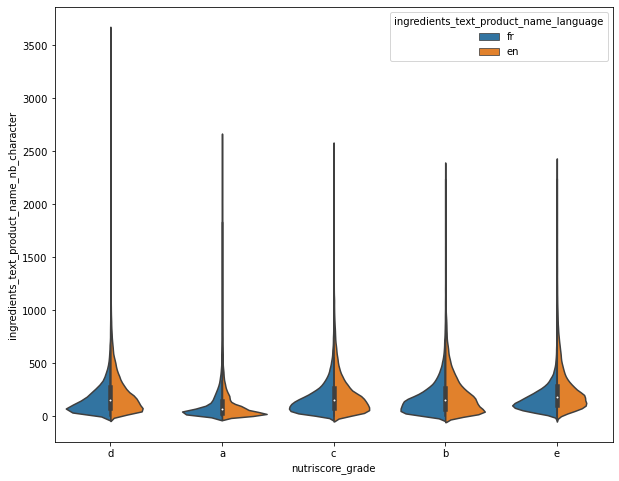

In [102]:
plt.figure(figsize = (10, 8))
sns.violinplot(x= 'nutriscore_grade',y= 'ingredients_text_product_name_nb_character', hue="ingredients_text_product_name_language",  data=df_en_fr, split = True, scale = 'area')
plt.savefig(os.path.join('charts', 'violon_text_nb_character.png'))

In [103]:
_nutriscores = df.groupby('nutriscore_grade').nutriscore_score.mean()

<Figure size 432x288 with 0 Axes>

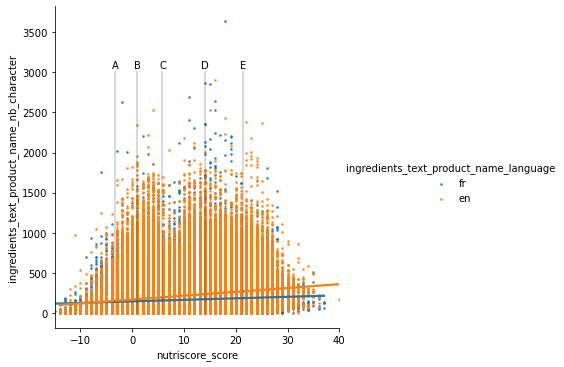

In [104]:
plt.figure()
sns.lmplot(
    x = 'nutriscore_score', 
    y = 'ingredients_text_product_name_nb_character', 
    hue = "ingredients_text_product_name_language", 
    data = df_en_fr,
    markers = '.',
    scatter_kws={"s":10}
)
for grade, score in _nutriscores.iteritems():
    plt.plot(np.full(shape = (10), fill_value = _nutriscores[grade]),
             np.linspace(0, 3000, 10), linestyle='-', alpha = 0.2, color = 'black')
    plt.text(x = _nutriscores[grade] - 0.6, y = 3050, s = grade.capitalize())
    
plt.savefig(os.path.join('charts', 'lineplot_nb_character.png'))

<Figure size 432x288 with 0 Axes>

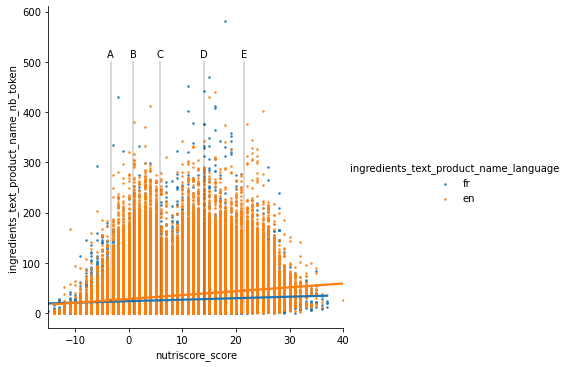

In [105]:
plt.figure()
sns.lmplot(
    x = 'nutriscore_score', 
    y = 'ingredients_text_product_name_nb_token', 
    hue = "ingredients_text_product_name_language", 
    data = df_en_fr,
    markers = '.',
    scatter_kws={"s":10}
)
for grade, score in _nutriscores.iteritems():
    plt.plot(np.full(shape = (10), fill_value = _nutriscores[grade]),
             np.linspace(0, 500, 10), linestyle='-', alpha = 0.2, color = 'black')
    plt.text(x = _nutriscores[grade] - 0.6, y = 510, s = grade.capitalize())
    
plt.savefig(os.path.join('charts', 'lineplot_nb_token.png'))

<Figure size 432x288 with 0 Axes>

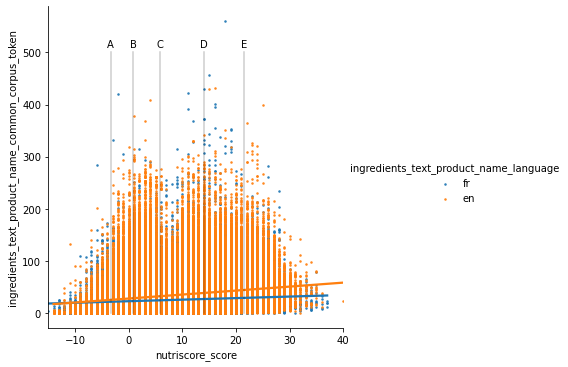

In [106]:
plt.figure()
sns.lmplot(
    x = 'nutriscore_score', 
    y = 'ingredients_text_product_name_common_corpus_token', 
    hue = "ingredients_text_product_name_language", 
    data = df_en_fr,
    markers = '.',
    scatter_kws={"s":10}
)
for grade, score in _nutriscores.iteritems():
    plt.plot(np.full(shape = (10), fill_value = _nutriscores[grade]),
             np.linspace(0, 500, 10), linestyle='-', alpha = 0.2, color = 'black')
    plt.text(x = _nutriscores[grade] - 0.6, y = 510, s = grade.capitalize())
    
plt.savefig(os.path.join('charts', 'lineplot_common_corpus_token.png'))

#### Heatmap

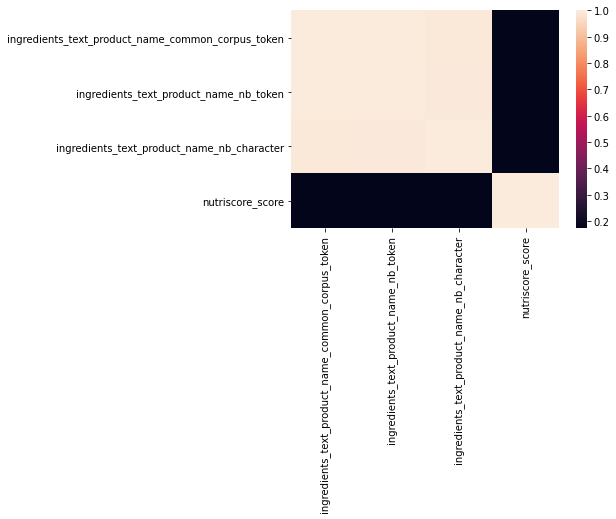

In [99]:
plt.figure()
sns.heatmap(df[[
    'ingredients_text_product_name_common_corpus_token', 
    'ingredients_text_product_name_nb_token',
    'ingredients_text_product_name_nb_character',
    'nutriscore_score',
]].corr())
plt.savefig(os.path.join('charts', f'heatmap_text.png'))

#### Anova

In [111]:
results = ols('ingredients_text_product_name_nb_token ~ nutriscore_grade', data=df).fit()
display(results.summary(alpha=.05))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     ingredients_text_product_name_nb_token   R-squared:                       0.039
Model:                                                OLS   Adj. R-squared:                  0.039
Method:                                     Least Squares   F-statistic:                     3713.
Date:                                    Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                                            23:25:44   Log-Likelihood:            -1.7854e+06
No. Observations:                                  370054   AIC:                         3.571e+06
Df Residuals:                                      370049   BIC:                         3.571e+06
Df Model:                                               4                                         
Covariance Type:                                nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                18.8718      0.125    150.738      0.000      18.626      19.117
nutriscore_grade[T.b]    14.8256      0.188     78.968      0.000      14.458      15.194
nutriscore_grade[T.c]    15.0555      0.166     90.666      0.000      14.730      15.381
nutriscore_grade[T.d]    16.0360      0.153    104.651      0.000      15.736      16.336
nutriscore_grade[T.e]    18.6387      0.168    111.150      0.000      18.310      18.967
==============================================================================
Omnibus:                   201694.401   Durbin-Watson:                   0.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2032861.178
Skew:                           2.453   Prob(JB):                         0.00
Kurtosis:                      13.382   Cond. No.                         6.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
results = ols('ingredients_text_product_name_nb_character ~ nutriscore_grade', data=df).fit()
display(results.summary(alpha=.05))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                        
======================================================================================================
Dep. Variable:     ingredients_text_product_name_nb_character   R-squared:                       0.040
Model:                                                    OLS   Adj. R-squared:                  0.040
Method:                                         Least Squares   F-statistic:                     3816.
Date:                                        Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                                                23:25:57   Log-Likelihood:            -2.4569e+06
No. Observations:                                      370054   AIC:                         4.914e+06
Df Residuals:                                          370049   BIC:                         4.914e+06
Df Model:                                                   4                                         
Covariance Type:                                    nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               113.4412      0.768    147.623      0.000     111.935     114.947
nutriscore_grade[T.b]    90.2384      1.152     78.308      0.000      87.980      92.497
nutriscore_grade[T.c]    92.5726      1.019     90.825      0.000      90.575      94.570
nutriscore_grade[T.d]    99.7673      0.941    106.074      0.000      97.924     101.611
nutriscore_grade[T.e]   116.5565      1.029    113.241      0.000     114.539     118.574
==============================================================================
Omnibus:                   202838.442   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2094794.071
Skew:                           2.461   Prob(JB):                         0.00
Kurtosis:                      13.565   Cond. No.                         6.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
results = ols('ingredients_text_product_name_common_corpus_token ~ nutriscore_grade', data=df).fit()
display(results.summary(alpha=.05))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                           
=============================================================================================================
Dep. Variable:     ingredients_text_product_name_common_corpus_token   R-squared:                       0.039
Model:                                                           OLS   Adj. R-squared:                  0.039
Method:                                                Least Squares   F-statistic:                     3748.
Date:                                               Mon, 22 Mar 2021   Prob (F-statistic):               0.00
Time:                                                       23:26:02   Log-Likelihood:            -1.7808e+06
No. Observations:                                             370054   AIC:                         3.562e+06
Df Residuals:                                                 370049   BIC:                         3.562e+06
Df Model:                                                          4                                         
Covariance Type:                                           nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                18.4055      0.124    148.849      0.000      18.163      18.648
nutriscore_grade[T.b]    14.6294      0.185     78.896      0.000      14.266      14.993
nutriscore_grade[T.c]    14.9670      0.164     91.258      0.000      14.646      15.288
nutriscore_grade[T.d]    15.9639      0.151    105.481      0.000      15.667      16.261
nutriscore_grade[T.e]    18.4605      0.166    111.462      0.000      18.136      18.785
==============================================================================
Omnibus:                   200911.986   Durbin-Watson:                   0.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1991166.838
Skew:                           2.447   Prob(JB):                         0.00
Kurtosis:                      13.256   Cond. No.                         6.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Image variables

Téléchargement des images : 

In [ ]:
i = 0
for index, url in tqdm(df.image_url.dropna().iteritems()):
    i += 1
    time.sleep(0.1)
    try:
        urllib.request.urlretrieve(url, os.path.join(storage_path, 'images', f"{str(index)}_{i}.jpg"))
    except:
        print(url)

In [ ]:
df.image_url.notna().sum()

In [ ]:
images_names = os.listdir(os.path.join(storage_path, 'images'))
print(len(images_names))

In [ ]:
img = image.imread(os.path.join(storage_path, 'images', images_names[1]))
plt.imshow(img)

Extraction de métriques à partir des images : 

In [ ]:
R_mean, G_mean, B_mean = dict(), dict(), dict()
R_min, G_min, B_min = dict(), dict(), dict()
R_max, G_max, B_max = dict(), dict(), dict()
R_sum, G_sum, B_sum = dict(), dict(), dict()
R_std, G_std, B_std = dict(), dict(), dict()

for img in tqdm(images_names):
    try:
        array = image.imread(os.path.join(storage_path, 'images', img))

        R = array[:,:,0].mean()
        G = array[:,:,1].mean()
        B = array[:,:,2].mean()

        R_mean[int(img[:-4])] = R
        G_mean[int(img[:-4])] = G
        B_mean[int(img[:-4])] = B

        R = array[:,:,0].min()
        G = array[:,:,1].min()
        B = array[:,:,2].min()

        R_min[int(img[:-4])] = R
        G_min[int(img[:-4])] = G
        B_min[int(img[:-4])] = B

        R = array[:,:,0].max()
        G = array[:,:,1].max()
        B = array[:,:,2].max()

        R_max[int(img[:-4])] = R
        G_max[int(img[:-4])] = G
        B_max[int(img[:-4])] = B

        R = array[:,:,0].sum()
        G = array[:,:,1].sum()
        B = array[:,:,2].sum()

        R_sum[int(img[:-4])] = R
        G_sum[int(img[:-4])] = G
        B_sum[int(img[:-4])] = B

        R = array[:,:,0].std()
        G = array[:,:,1].std()
        B = array[:,:,2].std()

        R_std[int(img[:-4])] = R
        G_std[int(img[:-4])] = G
        B_std[int(img[:-4])] = B
        
    except:
        print(img)

In [ ]:
for color in ['R', 'G', 'B']:
    for metric in ['mean', 'min', 'max', 'sum', 'std']:
        pickle.dump(locals()[color + '_' + metric], open(os.path.join(storage_path, color + '_' + metric + '.p'), 'wb'))

In [114]:
for color in ['R', 'G', 'B']:
    for metric in ['mean', 'min', 'max', 'sum', 'std']:
        locals()[color + '_' + metric] = pd.Series(pickle.load(open(os.path.join(storage_path, color + '_' + metric + '.p'), 'rb'))).sort_index()

In [115]:
for color in ['R', 'G', 'B']:
    for metric in ['mean', 'min', 'max', 'sum', 'std']:
        df['image_url_' + color + '_' + metric] = locals()[color + '_' + metric]

In [117]:
df.to_feather(os.path.join(storage_path, 'data.f'))

In [ ]:
df.shape

#### Analyse univariée

CPU times: user 49.9 s, sys: 20.2 s, total: 1min 10s
Wall time: 37 s


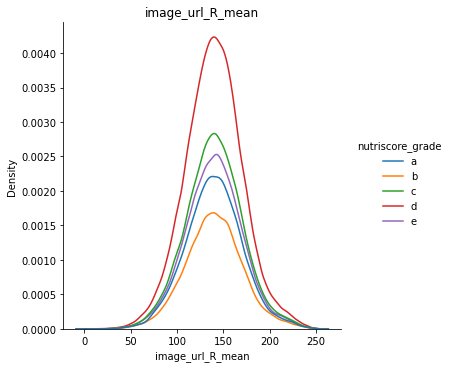

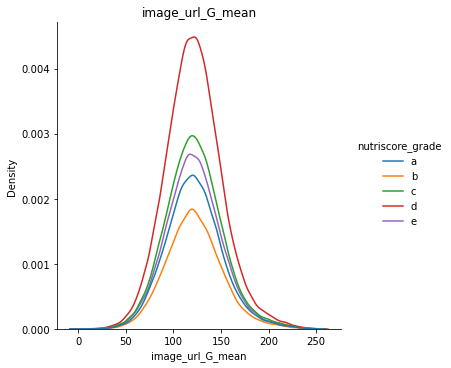

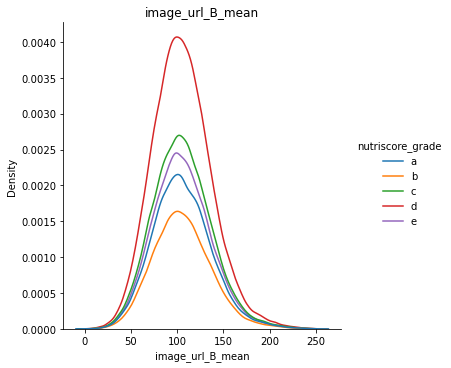

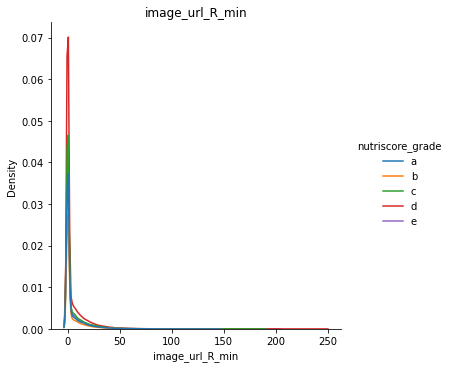

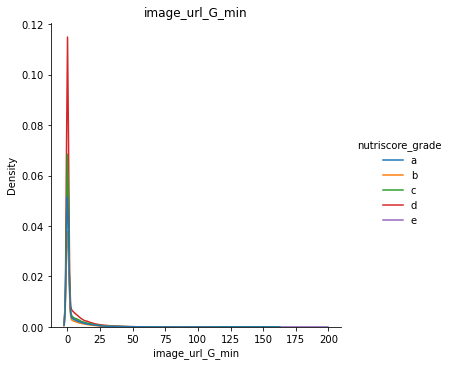

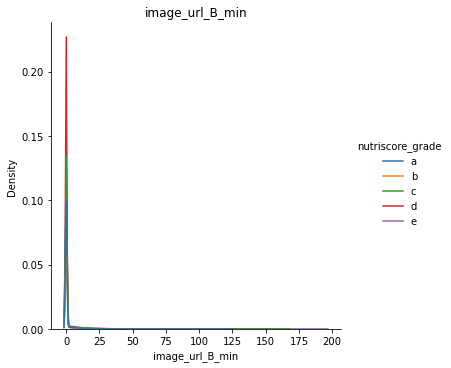

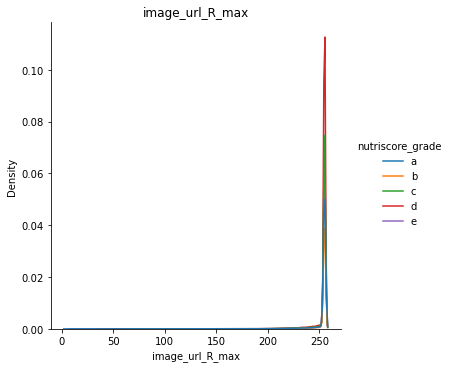

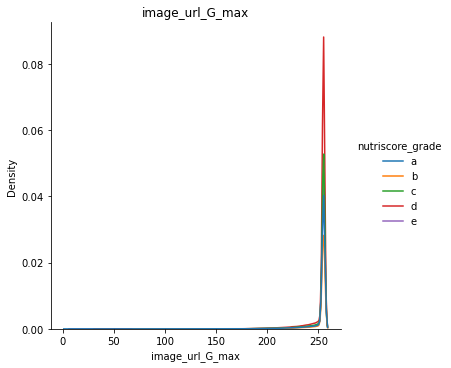

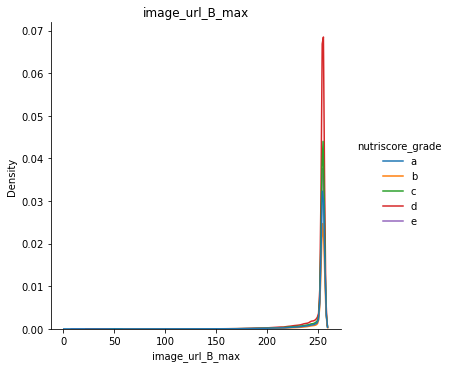

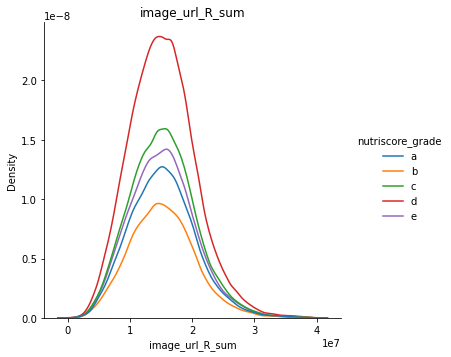

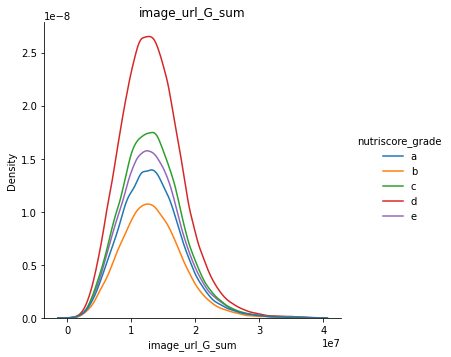

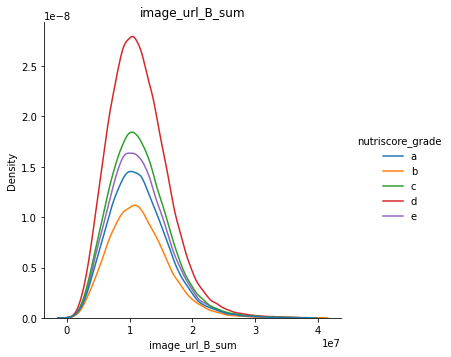

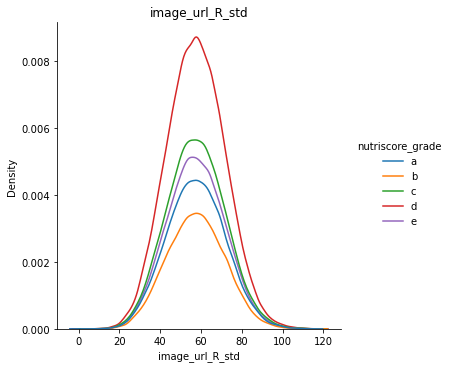

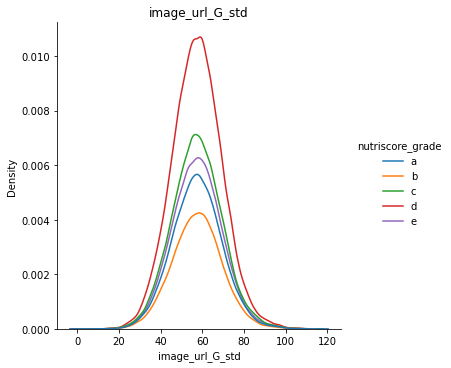

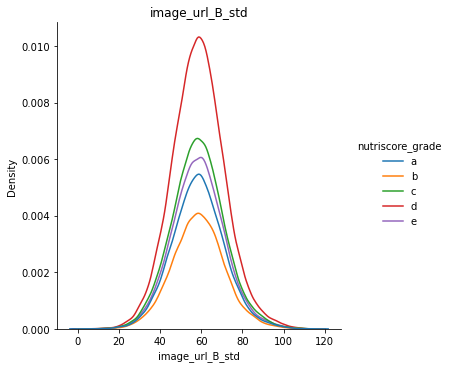

In [126]:
%%time
#data = df.sample(10000)
for metric in ['mean', 'min', 'max', 'sum', 'std']:
     for index, color in enumerate(['R', 'G', 'B']):
            var = f"image_url_{color}_{metric}"
            sns.displot(x = var, hue = 'nutriscore_grade', data = df, kind  = 'kde', hue_order = ['a', 'b', 'c', 'd', 'e'])
            plt.title(var)

#### Analyse bivariée

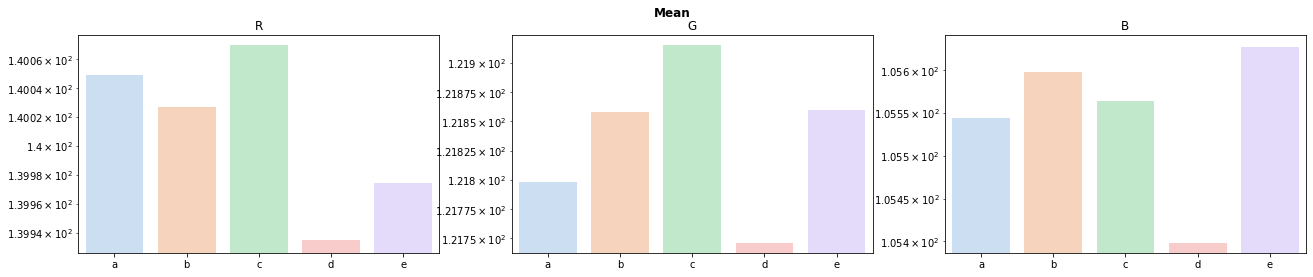

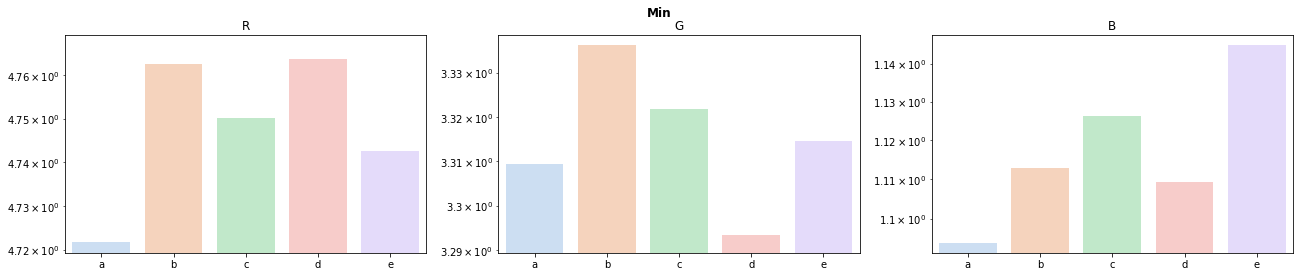

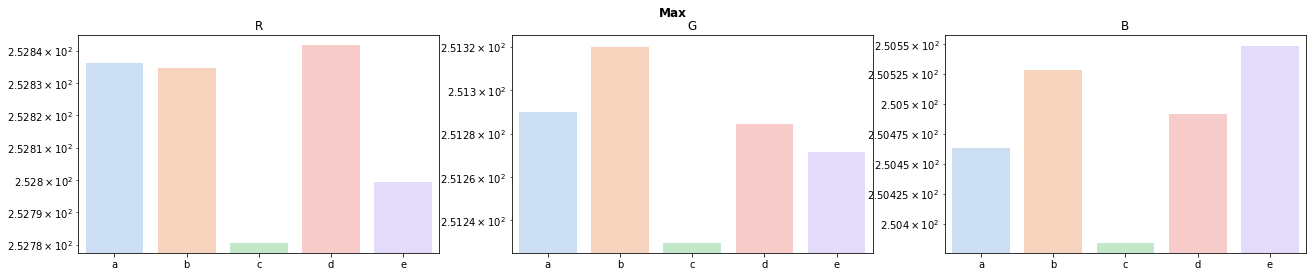

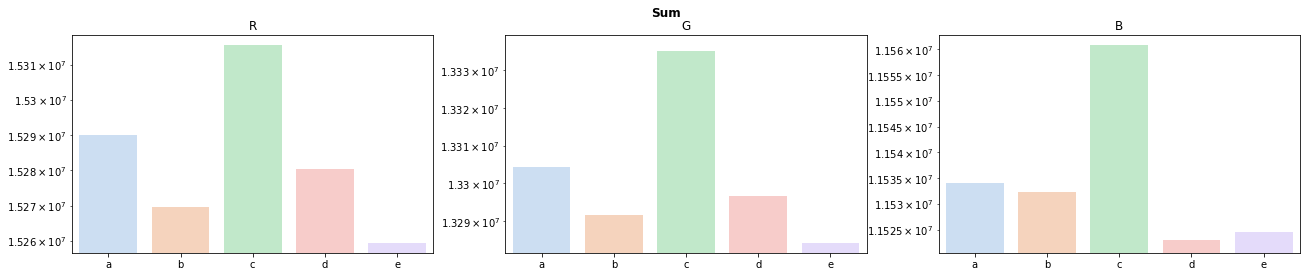

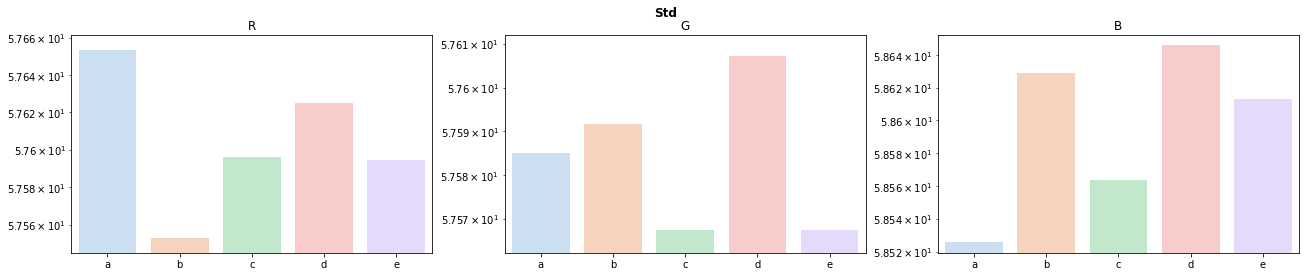

In [132]:
for metric in ['mean', 'min', 'max', 'sum', 'std']:
    plt.figure(figsize = (22, 4))
    plt.suptitle(metric.title(), weight = 'bold')
    for index, color in enumerate(['R', 'G', 'B']):
        plt.subplot(1, 3, index + 1)
        sns.barplot(x = 'nutriscore_grade', y = f'image_url_{color}_{metric}', data = df, palette="pastel", alpha = 0.6, order = ['a', 'b', 'c', 'd', 'e'], ci = 0)
        plt.title(color)
        plt.xlabel("")
        plt.ylabel("")
        plt.yscale('log')
        plt.yticks([])
    plt.savefig(os.path.join('charts', f'barplot_images_{metric}.png'))

#### Heatmap

In [119]:
_img_columns = [f'image_url_{color}_{metric}' for metric in ['mean', 'min', 'max', 'sum', 'std'] for color in ['R', 'G', 'B']]

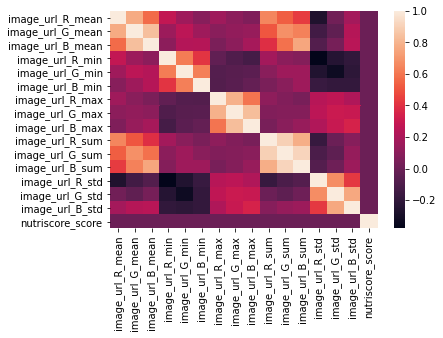

In [120]:
plt.figure()
sns.heatmap(df[_img_columns + ['nutriscore_score']].corr())
plt.savefig(os.path.join('charts', f'heatmap_image.png'))

#### Anova

In [123]:
for metric in ['mean', 'min', 'max', 'sum', 'std']:
    for color in ['R', 'G', 'B']:
        results = ols(f'image_url_{color}_{metric} ~ nutriscore_grade', data=df).fit()
        print(f"\n{24*' '}image_url_{color}_{metric}\n{60*'_'}")
        display(results.summary())


                        image_url_R_mean
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       image_url_R_mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2368
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.918
Time:                        23:32:35   Log-Likelihood:            -1.4990e+06
No. Observations:              308929   AIC:                         2.998e+06
Df Residuals:                  308924   BIC:                         2.998e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               140.0487      0.138   1018.404      0.000     139.779     140.318
nutriscore_grade[T.b]    -0.0219      0.209     -0.105      0.916      -0.432       0.388
nutriscore_grade[T.c]     0.0209      0.184      0.113      0.910      -0.340       0.382
nutriscore_grade[T.d]    -0.1137      0.170     -0.670      0.503      -0.446       0.219
nutriscore_grade[T.e]    -0.0746      0.189     -0.396      0.692      -0.444       0.295
==============================================================================
Omnibus:                      929.632   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1156.125
Skew:                           0.054   Prob(JB):                    8.93e-252
Kurtosis:                       3.279   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_G_mean
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       image_url_G_mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3623
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.836
Time:                        23:32:37   Log-Likelihood:            -1.4859e+06
No. Observations:              308929   AIC:                         2.972e+06
Df Residuals:                  308924   BIC:                         2.972e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               121.7977      0.132    924.096      0.000     121.539     122.056
nutriscore_grade[T.b]     0.0600      0.200      0.300      0.765      -0.333       0.453
nutriscore_grade[T.c]     0.1174      0.176      0.666      0.506      -0.228       0.463
nutriscore_grade[T.d]    -0.0516      0.163     -0.318      0.751      -0.370       0.267
nutriscore_grade[T.e]     0.0618      0.181      0.342      0.732      -0.292       0.416
==============================================================================
Omnibus:                     6935.041   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8500.883
Skew:                           0.306   Prob(JB):                         0.00
Kurtosis:                       3.535   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_B_mean
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       image_url_B_mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6175
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.650
Time:                        23:32:39   Log-Likelihood:            -1.5062e+06
No. Observations:              308929   AIC:                         3.012e+06
Df Residuals:                  308924   BIC:                         3.012e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               105.5443      0.141    749.957      0.000     105.268     105.820
nutriscore_grade[T.b]     0.0532      0.214      0.249      0.804      -0.366       0.473
nutriscore_grade[T.c]     0.0200      0.188      0.106      0.916      -0.349       0.389
nutriscore_grade[T.d]    -0.1461      0.174     -0.842      0.400      -0.486       0.194
nutriscore_grade[T.e]     0.0821      0.193      0.426      0.670      -0.296       0.460
==============================================================================
Omnibus:                     9561.416   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11088.779
Skew:                           0.401   Prob(JB):                         0.00
Kurtosis:                       3.467   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_R_min
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_R_min   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1527
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.962
Time:                        23:32:41   Log-Likelihood:            -1.1659e+06
No. Observations:              308929   AIC:                         2.332e+06
Df Residuals:                  308924   BIC:                         2.332e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.7218      0.047    100.930      0.000       4.630       4.814
nutriscore_grade[T.b]     0.0408      0.071      0.574      0.566      -0.099       0.180
nutriscore_grade[T.c]     0.0283      0.063      0.453      0.651      -0.094       0.151
nutriscore_grade[T.d]     0.0418      0.058      0.725      0.468      -0.071       0.155
nutriscore_grade[T.e]     0.0208      0.064      0.324      0.746      -0.105       0.147
==============================================================================
Omnibus:                   245584.570   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6563014.284
Skew:                           3.701   Prob(JB):                         0.00
Kurtosis:                      24.332   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_G_min
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_G_min   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2559
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.906
Time:                        23:32:43   Log-Likelihood:            -1.0756e+06
No. Observations:              308929   AIC:                         2.151e+06
Df Residuals:                  308924   BIC:                         2.151e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.3094      0.035     94.761      0.000       3.241       3.378
nutriscore_grade[T.b]     0.0269      0.053      0.506      0.613      -0.077       0.131
nutriscore_grade[T.c]     0.0125      0.047      0.267      0.790      -0.079       0.104
nutriscore_grade[T.d]    -0.0160      0.043     -0.372      0.710      -0.100       0.068
nutriscore_grade[T.e]     0.0052      0.048      0.108      0.914      -0.089       0.099
==============================================================================
Omnibus:                   254253.256   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7616208.942
Skew:                           3.859   Prob(JB):                         0.00
Kurtosis:                      26.067   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_B_min
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_B_min   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8209
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.512
Time:                        23:32:45   Log-Likelihood:            -9.3808e+05
No. Observations:              308929   AIC:                         1.876e+06
Df Residuals:                  308924   BIC:                         1.876e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.0939      0.022     48.889      0.000       1.050       1.138
nutriscore_grade[T.b]     0.0189      0.034      0.555      0.579      -0.048       0.086
nutriscore_grade[T.c]     0.0324      0.030      1.084      0.279      -0.026       0.091
nutriscore_grade[T.d]     0.0155      0.028      0.563      0.573      -0.039       0.070
nutriscore_grade[T.e]     0.0509      0.031      1.659      0.097      -0.009       0.111
==============================================================================
Omnibus:                   414085.169   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        113963587.058
Skew:                           7.661   Prob(JB):                         0.00
Kurtosis:                      95.837   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_R_max
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_R_max   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5955
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.666
Time:                        23:32:47   Log-Likelihood:            -1.1159e+06
No. Observations:              308929   AIC:                         2.232e+06
Df Residuals:                  308924   BIC:                         2.232e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               252.8362      0.040   6354.006      0.000     252.758     252.914
nutriscore_grade[T.b]    -0.0014      0.060     -0.024      0.981      -0.120       0.117
nutriscore_grade[T.c]    -0.0556      0.053     -1.044      0.296      -0.160       0.049
nutriscore_grade[T.d]     0.0055      0.049      0.112      0.911      -0.091       0.102
nutriscore_grade[T.e]    -0.0367      0.055     -0.672      0.501      -0.144       0.070
==============================================================================
Omnibus:                   360671.986   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         41668988.313
Skew:                          -6.229   Prob(JB):                         0.00
Kurtosis:                      58.516   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_G_max
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_G_max   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4201
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.794
Time:                        23:32:49   Log-Likelihood:            -1.1985e+06
No. Observations:              308929   AIC:                         2.397e+06
Df Residuals:                  308924   BIC:                         2.397e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               251.2902      0.052   4833.922      0.000     251.188     251.392
nutriscore_grade[T.b]     0.0297      0.079      0.375      0.707      -0.125       0.185
nutriscore_grade[T.c]    -0.0606      0.070     -0.871      0.384      -0.197       0.076
nutriscore_grade[T.d]    -0.0059      0.064     -0.093      0.926      -0.132       0.120
nutriscore_grade[T.e]    -0.0188      0.071     -0.263      0.792      -0.158       0.121
==============================================================================
Omnibus:                   292921.738   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12854167.437
Skew:                          -4.679   Prob(JB):                         0.00
Kurtosis:                      33.183   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_B_max
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_B_max   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.315
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.262
Time:                        23:32:50   Log-Likelihood:            -1.2445e+06
No. Observations:              308929   AIC:                         2.489e+06
Df Residuals:                  308924   BIC:                         2.489e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               250.4631      0.060   4151.159      0.000     250.345     250.581
nutriscore_grade[T.b]     0.0648      0.092      0.706      0.480      -0.115       0.245
nutriscore_grade[T.c]    -0.0788      0.081     -0.975      0.329      -0.237       0.079
nutriscore_grade[T.d]     0.0285      0.074      0.383      0.702      -0.117       0.174
nutriscore_grade[T.e]     0.0851      0.083      1.029      0.304      -0.077       0.247
==============================================================================
Omnibus:                   286127.707   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10926800.877
Skew:                          -4.561   Prob(JB):                         0.00
Kurtosis:                      30.670   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_R_sum
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_R_sum   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9937
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.409
Time:                        23:32:52   Log-Likelihood:            -5.2190e+06
No. Observations:              308929   AIC:                         1.044e+07
Df Residuals:                  308924   BIC:                         1.044e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.529e+07   2.33e+04    655.312      0.000    1.52e+07    1.53e+07
nutriscore_grade[T.b] -2.052e+04   3.55e+04     -0.578      0.563      -9e+04     4.9e+04
nutriscore_grade[T.c]  2.552e+04   3.12e+04      0.818      0.414   -3.57e+04    8.67e+04
nutriscore_grade[T.d] -9631.7609   2.88e+04     -0.335      0.738    -6.6e+04    4.68e+04
nutriscore_grade[T.e] -3.055e+04    3.2e+04     -0.955      0.340   -9.33e+04    3.22e+04
==============================================================================
Omnibus:                    10112.437   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11610.580
Skew:                           0.422   Prob(JB):                         0.00
Kurtosis:                       3.437   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_G_sum
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_G_sum   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.033
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.388
Time:                        23:32:54   Log-Likelihood:            -5.1917e+06
No. Observations:              308929   AIC:                         1.038e+07
Df Residuals:                  308924   BIC:                         1.038e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               1.33e+07   2.14e+04    623.024      0.000    1.33e+07    1.33e+07
nutriscore_grade[T.b] -1.272e+04   3.25e+04     -0.392      0.695   -7.64e+04    5.09e+04
nutriscore_grade[T.c]  3.083e+04   2.86e+04      1.079      0.281   -2.52e+04    8.68e+04
nutriscore_grade[T.d] -7665.4017   2.63e+04     -0.291      0.771   -5.93e+04    4.39e+04
nutriscore_grade[T.e] -2.006e+04   2.93e+04     -0.685      0.493   -7.75e+04    3.73e+04
==============================================================================
Omnibus:                    21050.515   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28969.388
Skew:                           0.600   Prob(JB):                         0.00
Kurtosis:                       3.902   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_B_sum
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_B_sum   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7169
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.580
Time:                        23:32:56   Log-Likelihood:            -5.1838e+06
No. Observations:              308929   AIC:                         1.037e+07
Df Residuals:                  308924   BIC:                         1.037e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.153e+07   2.08e+04    553.970      0.000    1.15e+07    1.16e+07
nutriscore_grade[T.b] -1784.8749   3.17e+04     -0.056      0.955   -6.38e+04    6.03e+04
nutriscore_grade[T.c]  2.672e+04   2.79e+04      0.959      0.338   -2.79e+04    8.13e+04
nutriscore_grade[T.d] -1.107e+04   2.57e+04     -0.431      0.666   -6.14e+04    3.92e+04
nutriscore_grade[T.e] -9480.8167   2.85e+04     -0.332      0.740   -6.54e+04    4.65e+04
==============================================================================
Omnibus:                    30647.994   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46939.199
Skew:                           0.748   Prob(JB):                         0.00
Kurtosis:                       4.188   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_R_std
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_R_std   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3390
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.852
Time:                        23:32:58   Log-Likelihood:            -1.2561e+06
No. Observations:              308929   AIC:                         2.512e+06
Df Residuals:                  308924   BIC:                         2.512e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                57.6533      0.063    920.413      0.000      57.531      57.776
nutriscore_grade[T.b]    -0.1006      0.095     -1.057      0.291      -0.287       0.086
nutriscore_grade[T.c]    -0.0571      0.084     -0.681      0.496      -0.221       0.107
nutriscore_grade[T.d]    -0.0283      0.077     -0.366      0.715      -0.180       0.123
nutriscore_grade[T.e]    -0.0587      0.086     -0.684      0.494      -0.227       0.110
==============================================================================
Omnibus:                      628.252   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.252
Skew:                           0.095   Prob(JB):                    1.12e-133
Kurtosis:                       2.891   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_G_std
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_G_std   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1508
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.963
Time:                        23:33:00   Log-Likelihood:            -1.2068e+06
No. Observations:              308929   AIC:                         2.414e+06
Df Residuals:                  308924   BIC:                         2.414e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                57.5851      0.053   1078.458      0.000      57.480      57.690
nutriscore_grade[T.b]     0.0066      0.081      0.081      0.935      -0.153       0.166
nutriscore_grade[T.c]    -0.0177      0.071     -0.248      0.804      -0.158       0.122
nutriscore_grade[T.d]     0.0221      0.066      0.336      0.737      -0.107       0.151
nutriscore_grade[T.e]    -0.0177      0.073     -0.242      0.809      -0.161       0.126
==============================================================================
Omnibus:                     1546.024   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1795.839
Skew:                           0.119   Prob(JB):                         0.00
Kurtosis:                       3.287   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


                        image_url_B_std
____________________________________________________________


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        image_url_B_std   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9286
Date:                Mon, 22 Mar 2021   Prob (F-statistic):              0.446
Time:                        23:33:02   Log-Likelihood:            -1.2270e+06
No. Observations:              308929   AIC:                         2.454e+06
Df Residuals:                  308924   BIC:                         2.454e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                58.5257      0.057   1026.539      0.000      58.414      58.637
nutriscore_grade[T.b]     0.1031      0.087      1.189      0.234      -0.067       0.273
nutriscore_grade[T.c]     0.0380      0.076      0.498      0.618      -0.111       0.188
nutriscore_grade[T.d]     0.1203      0.070      1.711      0.087      -0.017       0.258
nutriscore_grade[T.e]     0.0874      0.078      1.117      0.264      -0.066       0.241
==============================================================================
Omnibus:                     2076.163   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2564.858
Skew:                           0.128   Prob(JB):                         0.00
Kurtosis:                       3.366   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Serving size 

#### Exemples

In [3]:
df.serving_size.dropna().sample(10)

31077         1 MINI BURGER (70 g)
472036                         90g
425810                          1g
509031               100 g (100 g)
99382               1/4 cup (30 g)
131169             1 COOKIE (25 g)
84247              0.5 cup (125 g)
198192               1 CAKE (81 g)
429025                       310 g
622780    25 g, 17 pieces, 1/2 box
Name: serving_size, dtype: object

#### Preprocessing

Cleaning de serving size

In [6]:
def serving_size_preprocessing(_v):
    pat = '([0-9]+,[0-9]+\s+x)|([0-9]*\.[0-9]+\s+x)|([0-9]+\.[0-9]+x)|([0-9]+,[0-9]+x)|([0-9]+x)|([0-9]+\s+x)'
    try:
        _v = _v.lower()
        metric = 'g' 
        _pat = re.sub('x', metric, pat)
        if re.search(_pat, _v):
            _r = re.search(_pat, _v).group()
            _r = re.sub(metric, '', _r)
            _r = re.sub(',', '.', _r)
            return float(_r.strip())
        else:
            metric = 'ml' 
            _pat = re.sub('x', metric, pat)
            if re.search(_pat, _v):
                _r = re.search(_pat, _v).group()
                _r = re.sub(metric, '', _r)
                _r = re.sub(',', '.', _r)
                return float(_r.strip())
            else:
                metric = 'l' 
                _pat = re.sub('x', metric, pat)
                if re.search(_pat, _v):
                    _r = re.search(_pat, _v).group()
                    _r = re.sub(metric, '', _r)
                    _r = re.sub(',', '.', _r)
                    return float(_r.strip()) * 1000
                else:
                    metric = 'cl' 
                    _pat = re.sub('x', metric, pat)
                    if re.search(_pat, _v):
                        _r = re.search(_pat, _v).group()
                        _r = re.sub(metric, '', _r)
                        _r = re.sub(',', '.', _r)
                        return float(_r.strip()) * 10
                    else:
                        metric = 'oz' 
                        _pat = re.sub('x', metric, pat)
                        if re.search(_pat, _v):
                            _r = re.search(_pat, _v).group()
                            _r = re.sub(metric, '', _r)
                            _r = re.sub(',', '.', _r)
                            return float(_r.strip()) * 28.3495
                        else:
                            metric = 'kg' 
                            _pat = re.sub('x', metric, pat)
                            if re.search(_pat, _v):
                                _r = re.search(_pat, _v).group()
                                _r = re.sub(metric, '', _r)
                                _r = re.sub(',', '.', _r)
                                return float(_r.strip()) * 1000

    except:
        return np.NaN

In [7]:
df['serving_size_clean'] = df.serving_size.swifter.apply(serving_size_preprocessing)

Pandas Apply:   0%|          | 0/628740 [00:00<?, ?it/s]

In [8]:
df.to_feather(os.path.join(storage_path, 'data.f'))

#### Analyse univariée

<AxesSubplot:>

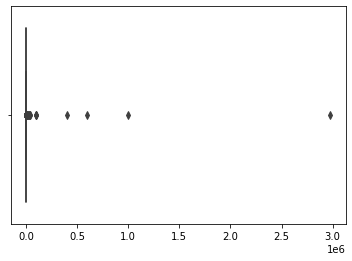

In [19]:
sns.boxplot(df.serving_size_clean.dropna().values)

Text(0.5, 1.0, 'Density (cut high quantile 0.99)')

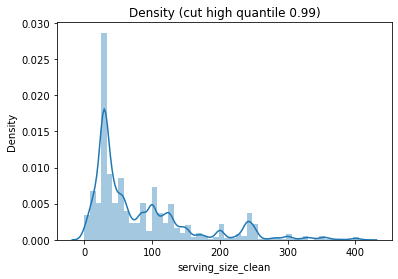

In [55]:
sns.distplot(_serie[(_serie < _serie.quantile(0.99)) & (_serie > _serie.quantile(0.0))])
plt.title('Density (cut high quantile 0.99)')

<AxesSubplot:xlabel='nutriscore_grade', ylabel='serving_size_clean'>

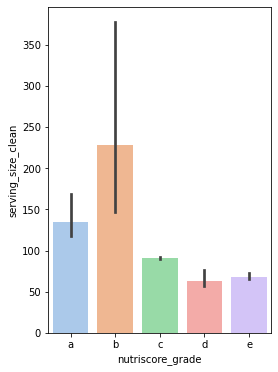

In [13]:
plt.figure(figsize = (4, 6))
sns.barplot(x = 'nutriscore_grade', y = 'serving_size_clean', data = df, palette = 'pastel', order = ['a', 'b', 'c', 'd', 'e'])

#### Anova

In [17]:
results = ols(f'serving_size_clean ~ nutriscore_grade', data=df).fit()
display(results.summary(alpha = .05))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     serving_size_clean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.906
Date:                Wed, 24 Mar 2021   Prob (F-statistic):           2.28e-06
Time:                        10:51:37   Log-Likelihood:            -3.3738e+06
No. Observations:              335906   AIC:                         6.748e+06
Df Residuals:                  335901   BIC:                         6.748e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               135.1516     22.476      6.013      0.000      91.098     179.205
nutriscore_grade[T.b]    92.4232     34.883      2.650      0.008      24.054     160.792
nutriscore_grade[T.c]   -44.1535     30.881     -1.430      0.153    -104.680      16.373
nutriscore_grade[T.d]   -71.7366     28.478     -2.519      0.012    -127.554     -15.920
nutriscore_grade[T.e]   -66.8383     31.907     -2.095      0.036    -129.375      -4.302
===============================================================================
Omnibus:                  2077871.556   Durbin-Watson:                    1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   849397217178411.000
Skew:                         476.448   Prob(JB):                          0.00
Kurtosis:                  246350.925   Cond. No.                          6.17
===============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# sanity check
df.serving_size_clean[df.serving_size_clean.isna()] = -1
df.serving_quantity[ df.serving_quantity.isna()] = -1
(df.serving_size_clean == df.serving_quantity).sum() / len(df.serving_size_clean)